# Definizione funzione di plot

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def plot_training_results(history, model, validation_generator):
    # Grafico di accuratezza (accuracy) di training e validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Grafico di perdita (loss) di training e validation
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Assuming you have a trained CNN model and validation generator
    # Replace 'model' with your actual trained CNN model and 'validation_generator' with your validation generator
    y_pred = model.predict(validation_generator, steps=len(validation_generator))

    # Get the true labels from the validation generator
    y_true = validation_generator.classes

    # Get the class names from the validation generator
    class_names = list(validation_generator.class_indices.keys())

    # Get the probability of the positive class (index 1)
    y_pred_positive = y_pred[:, 1]

    # Set a threshold for decision (e.g., 0.5) to convert probabilities to binary labels
    threshold = 0.5
    y_pred_classes = np.where(y_pred_positive > threshold, 1, 0)

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(y_true, y_pred_classes)

    # Compute ROC curve and ROC area for binary classification
    fpr, tpr, _ = roc_curve(y_true, y_pred_positive)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{class_names[1]} (AUC = {roc_auc:.2f})')  # Utilizza l'indice 1 per la classe positiva
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()

    # Get the true labels from the validation generator
    y_true = validation_generator.classes

    # Get the class names from the validation generator
    class_names = list(validation_generator.class_indices.keys())

    # Compute confusion matrix for binary classification
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

    # Plot confusion matrix with class names
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.grid(False)

    plt.show()
    # Calculate and print classification report (precision, recall, F1-score, support)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))


# Load del set di immagini tramite ImageDataGenerator

In questa sezione viene usata ImageDataGenerator per caricare ed applicare delle trasformazioni al set di immagini per permettere al modello di generalizzare più efficaciamente. Inoltre qui applico lo scaling alle immagini ritagliate da 128x128 portandole alla dimensione finale di 64x64

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Definisci il percorso della cartella contenente le immagini
train_set = 'data/cropped_uerd/train/'
validation_set = 'data/cropped_uerd/test/'

# Definisci la dimensione delle immagini
image_size = (64, 64)

# Definisci il rapporto di divisione tra train set e test set
train_test_split_ratio = 0.8

# Crea un oggetto ImageDataGenerator con le opportune configurazioni
data_generator = ImageDataGenerator(validation_split=1 - train_test_split_ratio, rescale = 1/255)
validation_generator = ImageDataGenerator(rescale = 1/255)

batch_size = 128

# Crea i generatori di dati per train set e test set utilizzando il metodo flow_from_directory
train_generator = data_generator.flow_from_directory(
    directory=train_set,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

test_generator = data_generator.flow_from_directory(
    directory=train_set,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

validation_generator = validation_generator.flow_from_directory(
    directory=validation_set,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 2500610 images belonging to 2 classes.
Found 625150 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.


# Primo esperimento



In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 123008)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                7872576   
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 7,876,290
Trainable params: 7,876,290
Non-trainable params: 0
____________________________________________

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 54s 1s/step - loss: 1.1067 - accuracy: 0.5031 - val_loss: 0.6938 - val_accuracy: 0.4978
Epoch 2/10
50/50 [==============================] - 52s 1s/step - loss: 0.6949 - accuracy: 0.4930 - val_loss: 0.6941 - val_accuracy: 0.5028
Epoch 3/10
50/50 [==============================] - 52s 1s/step - loss: 0.6941 - accuracy: 0.4948 - val_loss: 0.6941 - val_accuracy: 0.4988
Epoch 4/10
50/50 [==============================] - 51s 1s/step - loss: 0.6935 - accuracy: 0.5025 - val_loss: 0.6938 - val_accuracy: 0.4825
Epoch 5/10
50/50 [==============================] - 54s 1s/step - loss: 0.6939 - accuracy: 0.4967 - val_loss: 0.6933 - val_accuracy: 0.4994
Epoch 6/10
50/50 [==============================] - 60s 1s/step - loss: 0.6936 - accuracy: 0.5005 - val_loss: 0.6951 - val_accuracy: 0.4916
Epoch 7/10
50/50 [==============================] - 51s 1s/step - loss: 0.6935 - accuracy: 0.4978 - val_loss: 0.6936 - val_accuracy: 0.4991
Epoch 8/10
50/50 [==

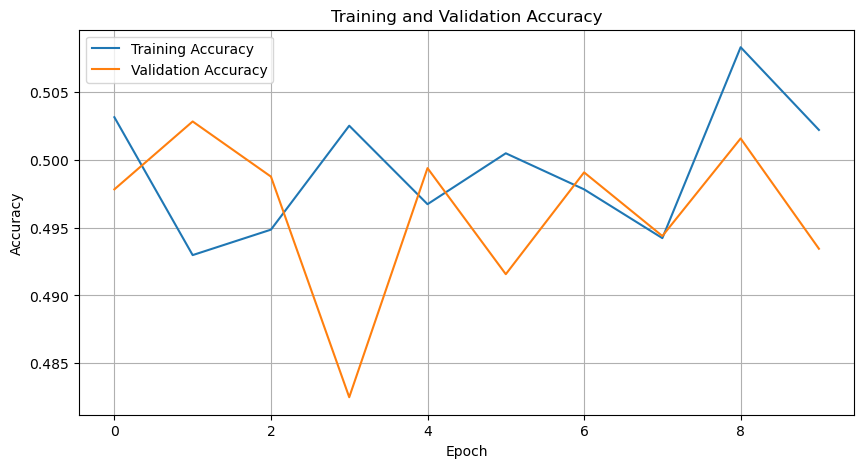

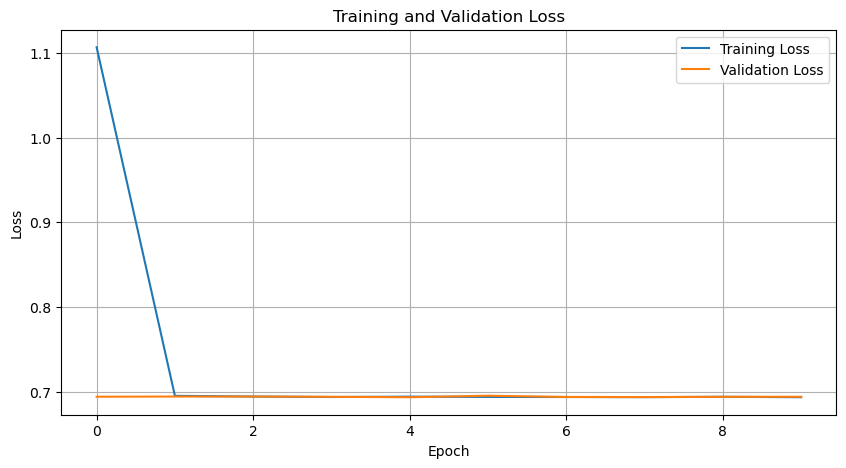

8/8 [==============================] - 2s 195ms/step


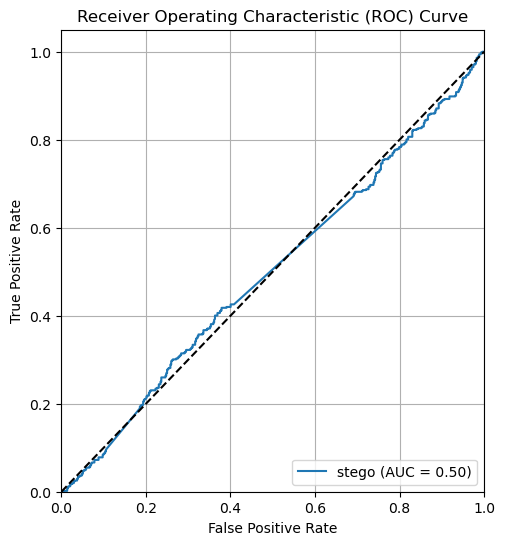

<Figure size 600x600 with 0 Axes>

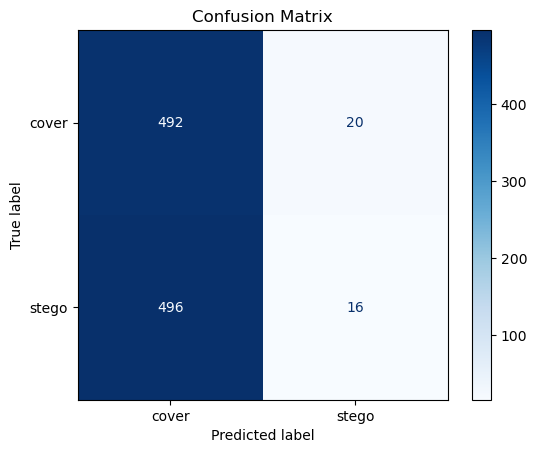


Classification Report:
              precision    recall  f1-score   support

       cover       0.50      0.96      0.66       512
       stego       0.44      0.03      0.06       512

    accuracy                           0.50      1024
   macro avg       0.47      0.50      0.36      1024
weighted avg       0.47      0.50      0.36      1024



In [43]:
plot_training_results(history, model, validation_generator)

# Secondo esperimento

In [46]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 128)       3584      
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 128)      0         
 ooling2D)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 64)        73792     
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 12544)             0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [47]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 54s 1s/step - loss: 0.7027 - accuracy: 0.5139 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 2/10
50/50 [==============================] - 53s 1s/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6930 - val_accuracy: 0.5081
Epoch 3/10
50/50 [==============================] - 53s 1s/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 4/10
50/50 [==============================] - 56s 1s/step - loss: 0.6933 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 5/10
50/50 [==============================] - 61s 1s/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6930 - val_accuracy: 0.5163
Epoch 6/10
50/50 [==============================] - 74s 1s/step - loss: 0.6933 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 7/10
50/50 [==============================] - 66s 1s/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 8/10
50/50 [==

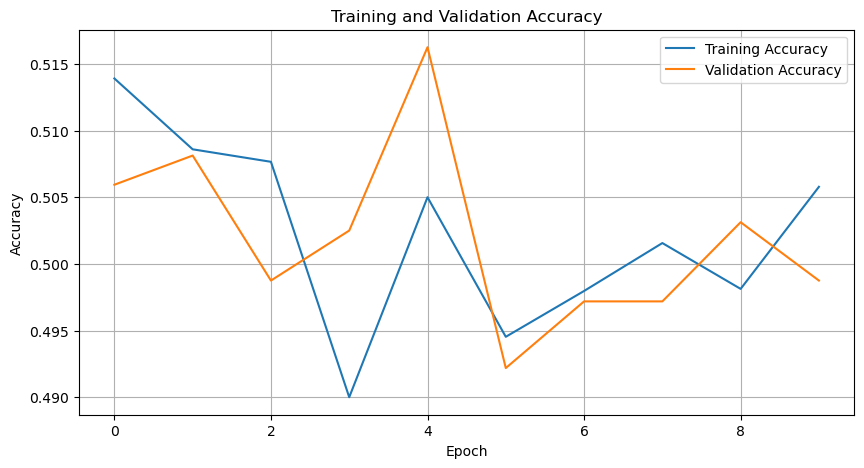

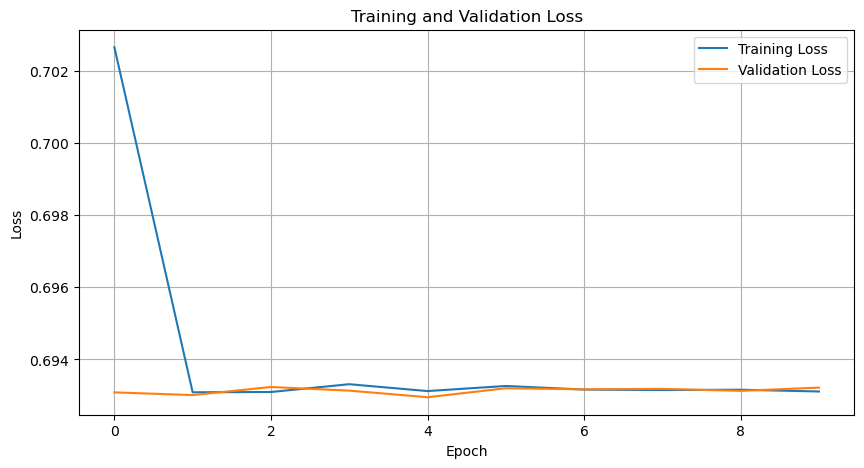

8/8 [==============================] - 3s 321ms/step


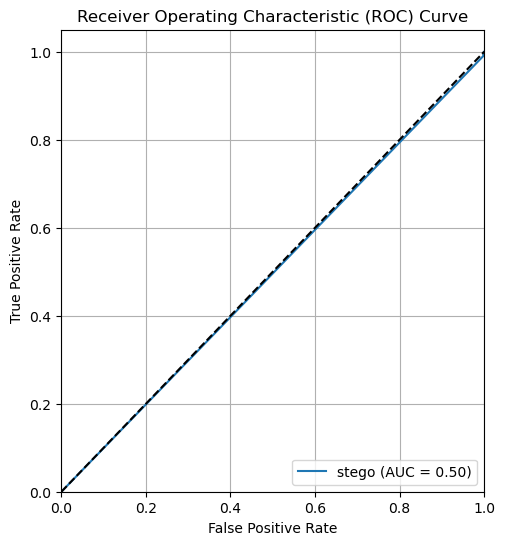

<Figure size 600x600 with 0 Axes>

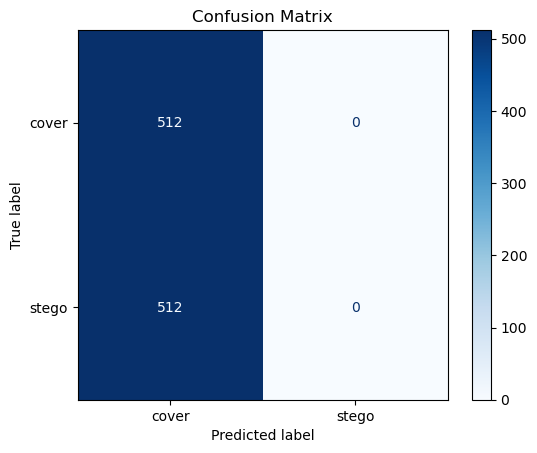


Classification Report:
              precision    recall  f1-score   support

       cover       0.50      1.00      0.67       512
       stego       0.00      0.00      0.00       512

    accuracy                           0.50      1024
   macro avg       0.25      0.50      0.33      1024
weighted avg       0.25      0.50      0.33      1024



c:\Users\peppe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peppe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\peppe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
plot_training_results(history, model, validation_generator)

# Terzo esperimento


In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 62, 62, 128)       3584      
                                                                 
 average_pooling2d_2 (Averag  (None, 31, 31, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 29, 29, 64)        73792     
                                                                 
 average_pooling2d_3 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                      

In [50]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 62s 1s/step - loss: 0.9681 - accuracy: 0.5133 - val_loss: 0.6950 - val_accuracy: 0.4969
Epoch 2/10
50/50 [==============================] - 60s 1s/step - loss: 0.7087 - accuracy: 0.4995 - val_loss: 0.6941 - val_accuracy: 0.4850
Epoch 3/10
50/50 [==============================] - 59s 1s/step - loss: 0.7006 - accuracy: 0.4998 - val_loss: 0.6933 - val_accuracy: 0.4919
Epoch 4/10
50/50 [==============================] - 60s 1s/step - loss: 0.6956 - accuracy: 0.5056 - val_loss: 0.6939 - val_accuracy: 0.4953
Epoch 5/10
50/50 [==============================] - 57s 1s/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 0.6931 - val_accuracy: 0.4981
Epoch 6/10
50/50 [==============================] - 59s 1s/step - loss: 0.6933 - accuracy: 0.5042 - val_loss: 0.6934 - val_accuracy: 0.4884
Epoch 7/10
50/50 [==============================] - 58s 1s/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6934 - val_accuracy: 0.4881
Epoch 8/10
50/50 [==

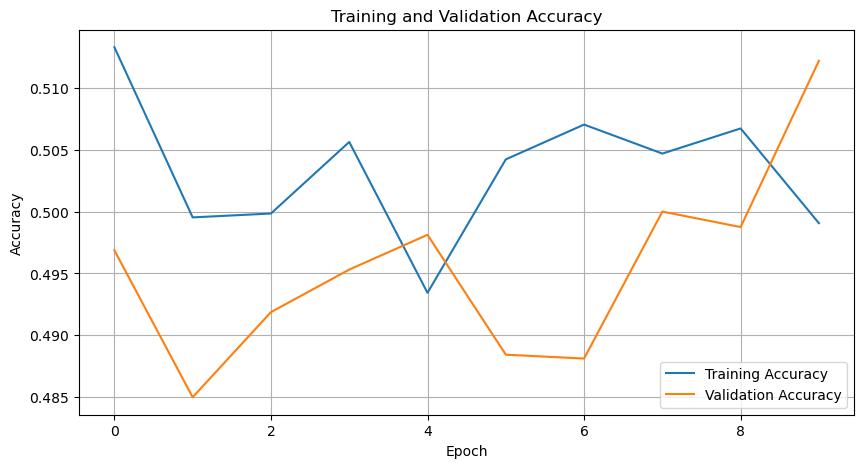

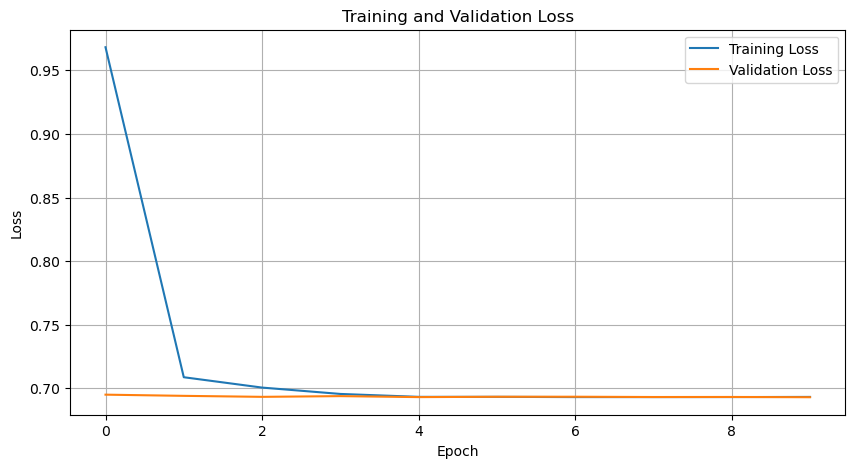

8/8 [==============================] - 2s 284ms/step


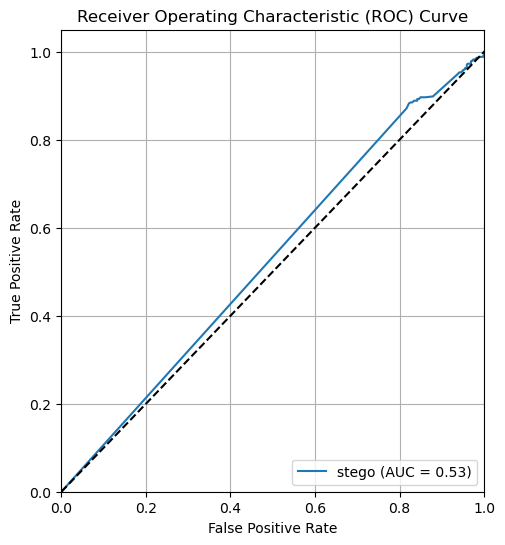

<Figure size 600x600 with 0 Axes>

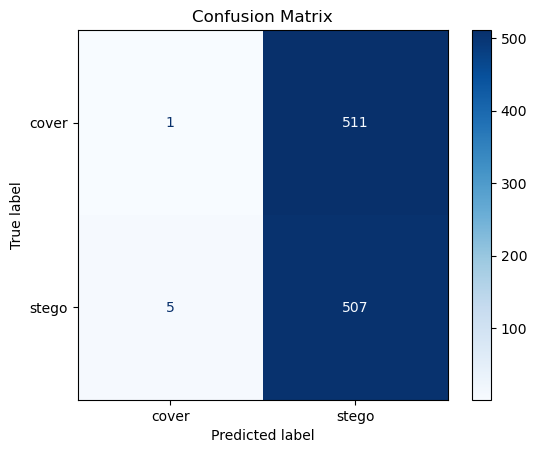


Classification Report:
              precision    recall  f1-score   support

       cover       0.17      0.00      0.00       512
       stego       0.50      0.99      0.66       512

    accuracy                           0.50      1024
   macro avg       0.33      0.50      0.33      1024
weighted avg       0.33      0.50      0.33      1024



In [51]:
plot_training_results(history, model, validation_generator)

# Quarto esperimento

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 128)       3584      
                                                                 
 average_pooling2d_4 (Averag  (None, 31, 31, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        73792     
                                                                 
 average_pooling2d_5 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 average_pooling2d_6 (Averag  (None, 6, 6, 64)       

In [53]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 61s 1s/step - loss: 0.7430 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.4991
Epoch 2/10
50/50 [==============================] - 61s 1s/step - loss: 0.7081 - accuracy: 0.5017 - val_loss: 0.6947 - val_accuracy: 0.5044
Epoch 3/10
50/50 [==============================] - 62s 1s/step - loss: 0.7068 - accuracy: 0.4980 - val_loss: 0.6937 - val_accuracy: 0.4966
Epoch 4/10
50/50 [==============================] - 69s 1s/step - loss: 0.7046 - accuracy: 0.4942 - val_loss: 0.6946 - val_accuracy: 0.5041
Epoch 5/10
50/50 [==============================] - 63s 1s/step - loss: 0.7019 - accuracy: 0.5084 - val_loss: 0.6964 - val_accuracy: 0.5006
Epoch 6/10
50/50 [==============================] - 64s 1s/step - loss: 0.7031 - accuracy: 0.5023 - val_loss: 0.6980 - val_accuracy: 0.4947
Epoch 7/10
50/50 [==============================] - 65s 1s/step - loss: 0.7004 - accuracy: 0.5033 - val_loss: 0.6948 - val_accuracy: 0.5081
Epoch 8/10
50/50 [==

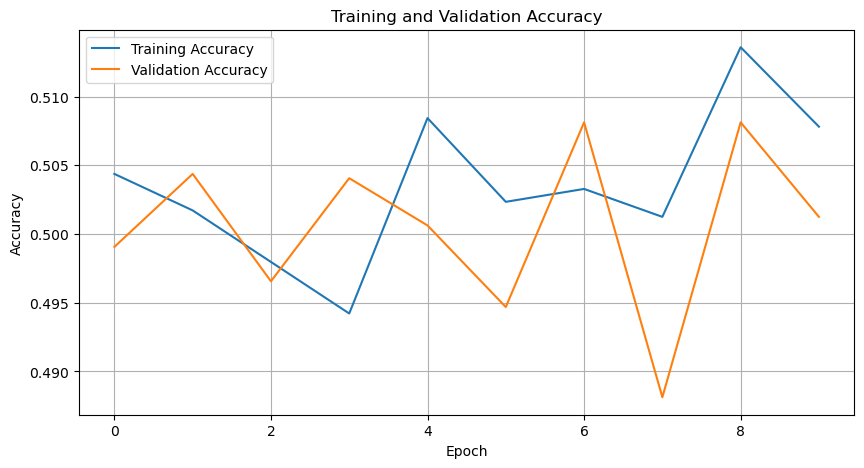

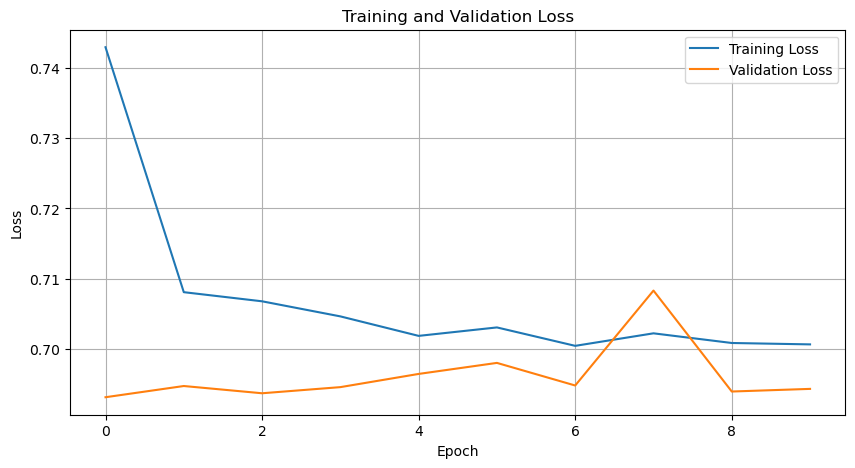

8/8 [==============================] - 2s 277ms/step


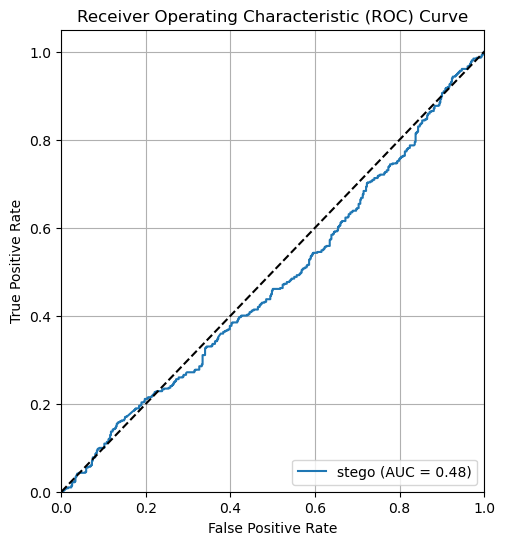

<Figure size 600x600 with 0 Axes>

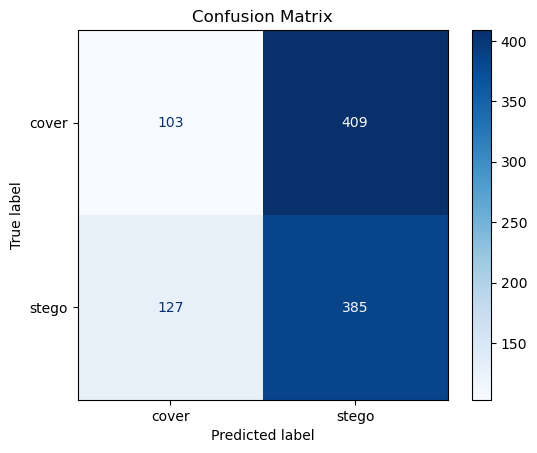


Classification Report:
              precision    recall  f1-score   support

       cover       0.45      0.20      0.28       512
       stego       0.48      0.75      0.59       512

    accuracy                           0.48      1024
   macro avg       0.47      0.48      0.43      1024
weighted avg       0.47      0.48      0.43      1024



In [54]:
plot_training_results(history, model, validation_generator)

# Quinto esperimento

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 128)       3584      
                                                                 
 average_pooling2d_8 (Averag  (None, 31, 31, 128)      0         
 ePooling2D)                                                     
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        73792     
                                                                 
 average_pooling2d_9 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                      

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 93s 2s/step - loss: 0.7377 - accuracy: 0.5052 - val_loss: 0.6981 - val_accuracy: 0.5038
Epoch 2/10
50/50 [==============================] - 84s 2s/step - loss: 0.7266 - accuracy: 0.4933 - val_loss: 0.6963 - val_accuracy: 0.4988
Epoch 3/10
50/50 [==============================] - 86s 2s/step - loss: 0.7175 - accuracy: 0.5038 - val_loss: 0.6950 - val_accuracy: 0.5047
Epoch 4/10
50/50 [==============================] - 85s 2s/step - loss: 0.7097 - accuracy: 0.5000 - val_loss: 0.7022 - val_accuracy: 0.4972
Epoch 5/10
50/50 [==============================] - 86s 2s/step - loss: 0.7058 - accuracy: 0.5005 - val_loss: 0.6964 - val_accuracy: 0.4928
Epoch 6/10
50/50 [==============================] - 87s 2s/step - loss: 0.7096 - accuracy: 0.5002 - val_loss: 0.6973 - val_accuracy: 0.4947
Epoch 7/10
50/50 [==============================] - 86s 2s/step - loss: 0.7035 - accuracy: 0.4986 - val_loss: 0.6988 - val_accuracy: 0.4966
Epoch 8/10
50/50 [==

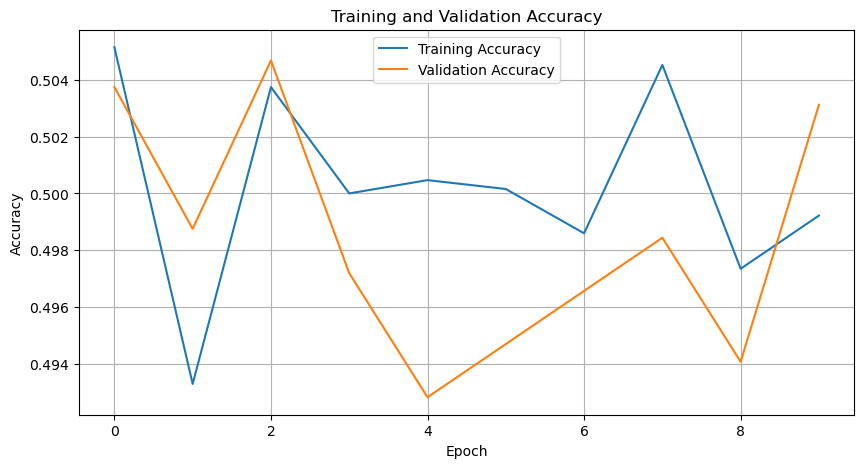

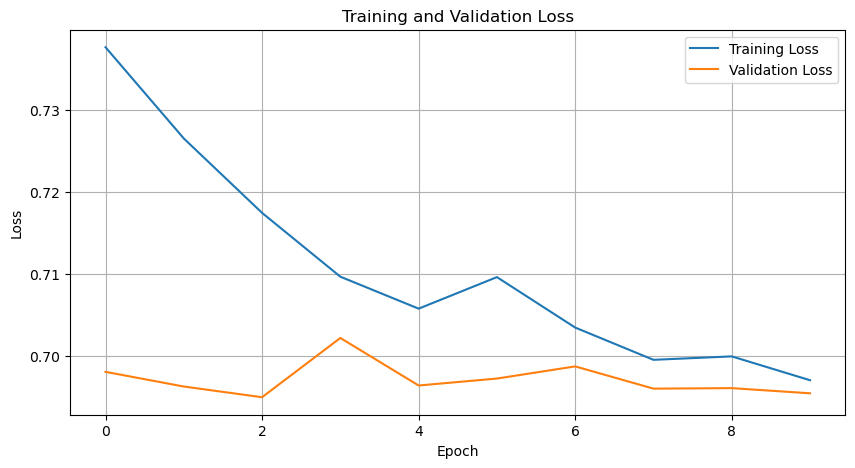

8/8 [==============================] - 4s 429ms/step


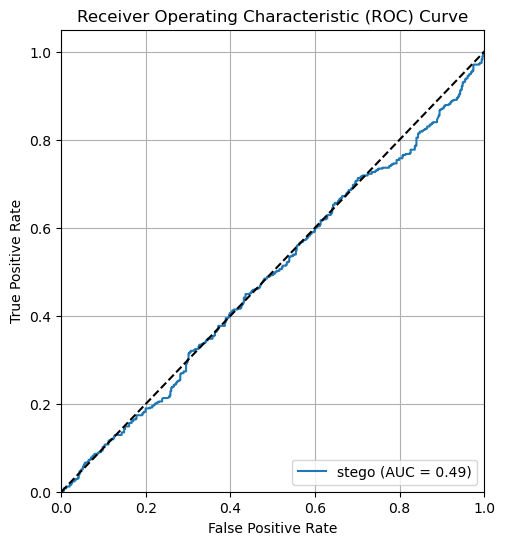

<Figure size 600x600 with 0 Axes>

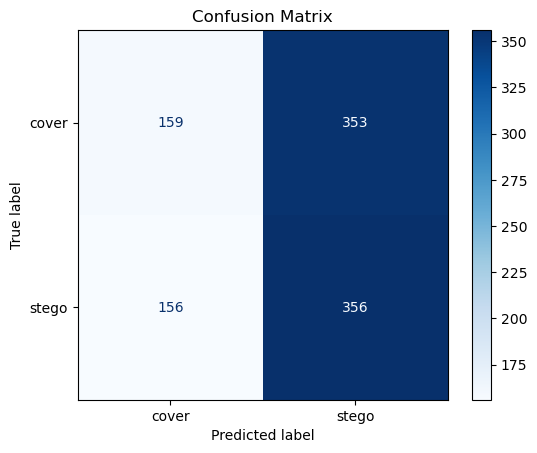


Classification Report:
              precision    recall  f1-score   support

       cover       0.50      0.31      0.38       512
       stego       0.50      0.70      0.58       512

    accuracy                           0.50      1024
   macro avg       0.50      0.50      0.48      1024
weighted avg       0.50      0.50      0.48      1024



In [13]:
plot_training_results(history, model, validation_generator)

# Sesto esperimento

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 62, 62, 128)       3584      
                                                                 
 average_pooling2d_27 (Avera  (None, 31, 31, 128)      0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_8 (Batc  (None, 31, 31, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 64)        73792     
                                                                 
 average_pooling2d_28 (Avera  (None, 14, 14, 64)       0         
 gePooling2D)                                                    
                                                     

In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 107s 2s/step - loss: 0.7122 - accuracy: 0.5045 - val_loss: 0.6933 - val_accuracy: 0.5025
Epoch 2/10
50/50 [==============================] - 100s 2s/step - loss: 0.7018 - accuracy: 0.4963 - val_loss: 0.6944 - val_accuracy: 0.4850
Epoch 3/10
50/50 [==============================] - 101s 2s/step - loss: 0.6991 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.4897
Epoch 4/10
50/50 [==============================] - 85s 2s/step - loss: 0.6973 - accuracy: 0.5005 - val_loss: 0.6986 - val_accuracy: 0.4884
Epoch 5/10
50/50 [==============================] - 85s 2s/step - loss: 0.6981 - accuracy: 0.4975 - val_loss: 0.6951 - val_accuracy: 0.5038
Epoch 6/10
50/50 [==============================] - 85s 2s/step - loss: 0.6962 - accuracy: 0.4995 - val_loss: 0.6938 - val_accuracy: 0.5066
Epoch 7/10
50/50 [==============================] - 86s 2s/step - loss: 0.6955 - accuracy: 0.4991 - val_loss: 0.6949 - val_accuracy: 0.5066
Epoch 8/10
50/50 

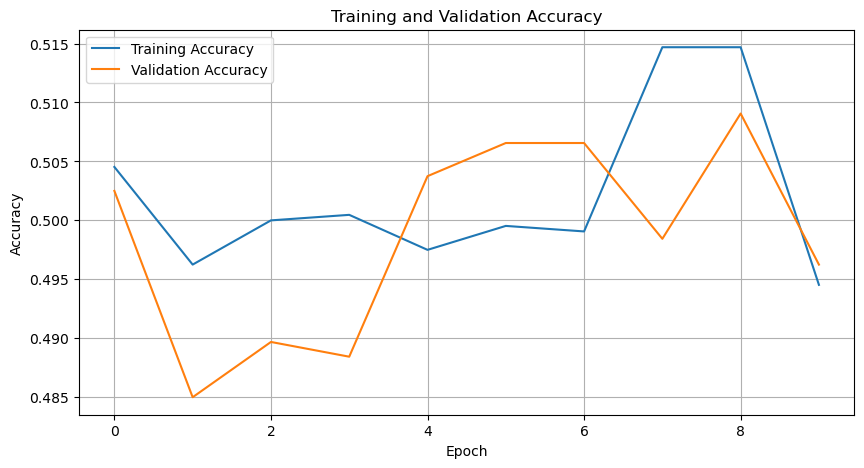

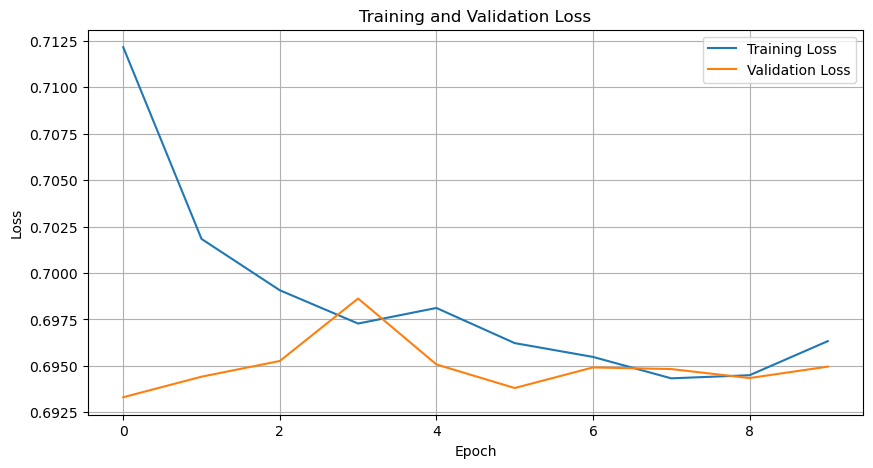

8/8 [==============================] - 5s 521ms/step


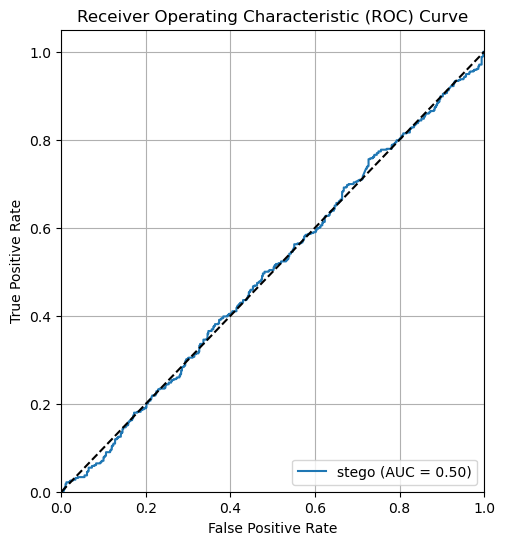

<Figure size 600x600 with 0 Axes>

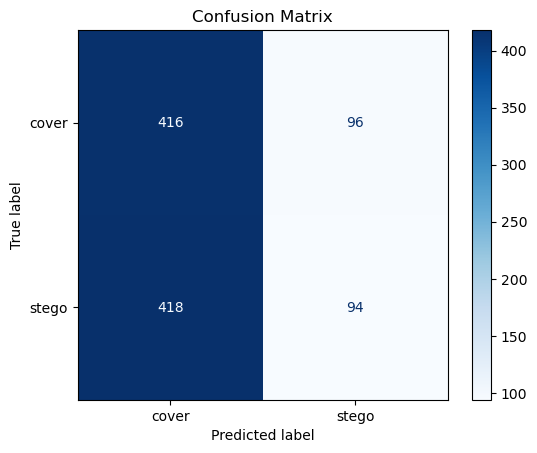


Classification Report:
              precision    recall  f1-score   support

       cover       0.50      0.81      0.62       512
       stego       0.49      0.18      0.27       512

    accuracy                           0.50      1024
   macro avg       0.50      0.50      0.44      1024
weighted avg       0.50      0.50      0.44      1024



In [31]:
plot_training_results(history, model, validation_generator)

# Settimo esperimento

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(256, kernel_size = (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 62, 62, 256)       7168      
                                                                 
 average_pooling2d_31 (Avera  (None, 31, 31, 256)      0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_12 (Bat  (None, 31, 31, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 29, 29, 128)       295040    
                                                                 
 average_pooling2d_32 (Avera  (None, 14, 14, 128)      0         
 gePooling2D)                                                    
                                                     

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 167s 3s/step - loss: 0.7128 - accuracy: 0.5045 - val_loss: 0.6953 - val_accuracy: 0.4963
Epoch 2/10
50/50 [==============================] - 155s 3s/step - loss: 0.6993 - accuracy: 0.5033 - val_loss: 0.6952 - val_accuracy: 0.5088
Epoch 3/10
50/50 [==============================] - 139s 3s/step - loss: 0.6956 - accuracy: 0.5011 - val_loss: 0.6923 - val_accuracy: 0.5222
Epoch 4/10
50/50 [==============================] - 157s 3s/step - loss: 0.6962 - accuracy: 0.5028 - val_loss: 0.6947 - val_accuracy: 0.4919
Epoch 5/10
50/50 [==============================] - 163s 3s/step - loss: 0.6958 - accuracy: 0.4958 - val_loss: 0.6938 - val_accuracy: 0.4928
Epoch 6/10
50/50 [==============================] - 143s 3s/step - loss: 0.6952 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 7/10
50/50 [==============================] - 140s 3s/step - loss: 0.6947 - accuracy: 0.5044 - val_loss: 0.6948 - val_accuracy: 0.4978
Epoch 8/10
50

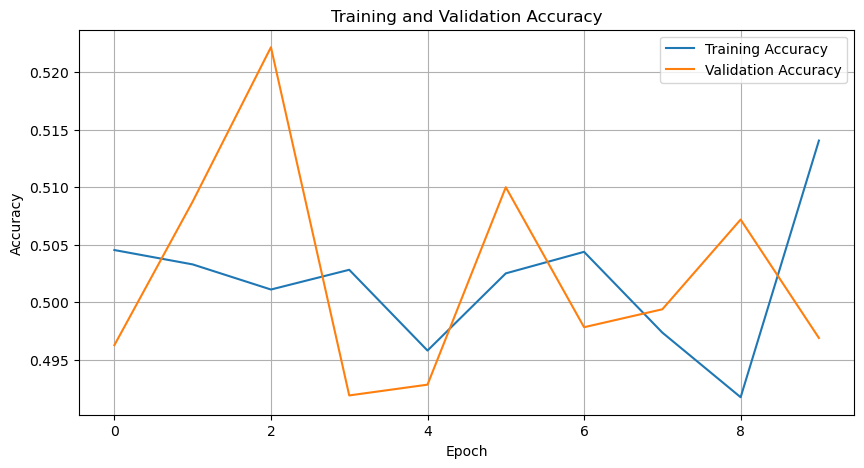

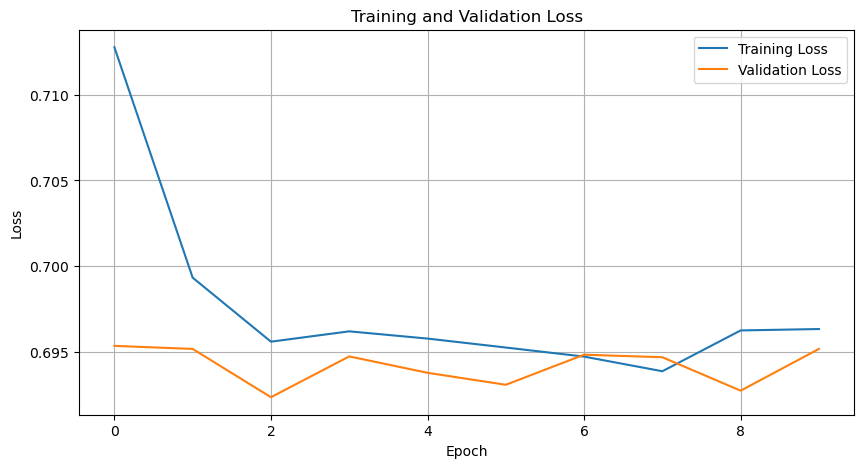

8/8 [==============================] - 9s 1s/step


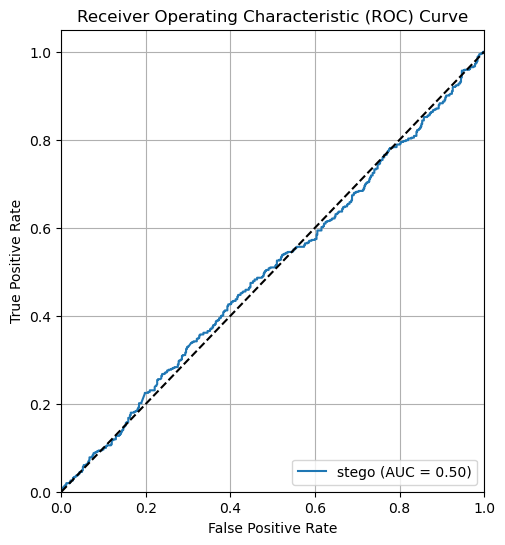

<Figure size 600x600 with 0 Axes>

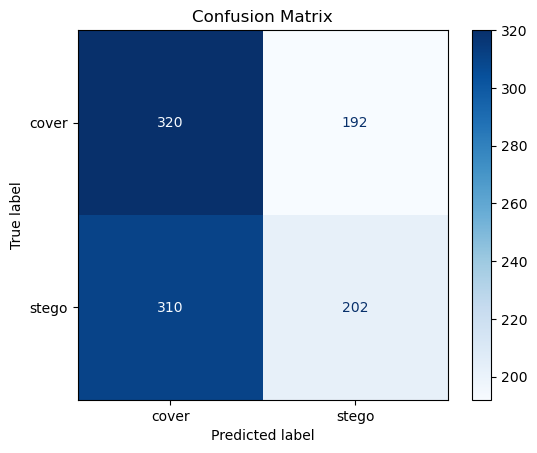


Classification Report:
              precision    recall  f1-score   support

       cover       0.51      0.62      0.56       512
       stego       0.51      0.39      0.45       512

    accuracy                           0.51      1024
   macro avg       0.51      0.51      0.50      1024
weighted avg       0.51      0.51      0.50      1024



In [34]:
plot_training_results(history, model, validation_generator)

# Ottavo esperimento facendo fine tuning con il modello pre-addestrato EfficientNetB0

Qui provo il modello CNN della google EfficientNetB0 che però si rivela non adatto per affrontare il problema

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(64,64,3),
    include_top=False,
    pooling='avg',
)

model = Sequential()
model.add(efficient_net)
model.add(BatchNormalization())
model.add(Dense(2, activation = "softmax"))
model.summary()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_7 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_23 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 4,057,253
Trainable params: 4,012,670
Non-trainable params: 44,583
_________________________________________________________________


In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 25
)

Epoch 1/10
50/50 [==============================] - 155s 3s/step - loss: 0.9949 - accuracy: 0.5056 - val_loss: 0.7336 - val_accuracy: 0.5059
Epoch 2/10
50/50 [==============================] - 124s 2s/step - loss: 0.8219 - accuracy: 0.5075 - val_loss: 0.6969 - val_accuracy: 0.4778
Epoch 3/10
50/50 [==============================] - 113s 2s/step - loss: 0.8254 - accuracy: 0.5138 - val_loss: 0.7148 - val_accuracy: 0.4916
Epoch 4/10
50/50 [==============================] - 119s 2s/step - loss: 0.7620 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 5/10
50/50 [==============================] - 114s 2s/step - loss: 0.7352 - accuracy: 0.5089 - val_loss: 0.6943 - val_accuracy: 0.4963
Epoch 6/10
50/50 [==============================] - 123s 2s/step - loss: 0.7331 - accuracy: 0.5009 - val_loss: 0.8899 - val_accuracy: 0.5034
Epoch 7/10
50/50 [==============================] - 124s 2s/step - loss: 0.7210 - accuracy: 0.4942 - val_loss: 0.7074 - val_accuracy: 0.4981
Epoch 8/10
50

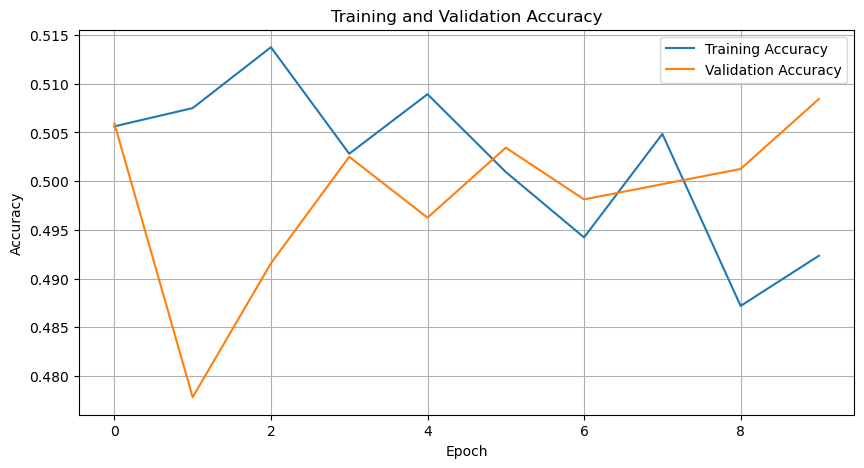

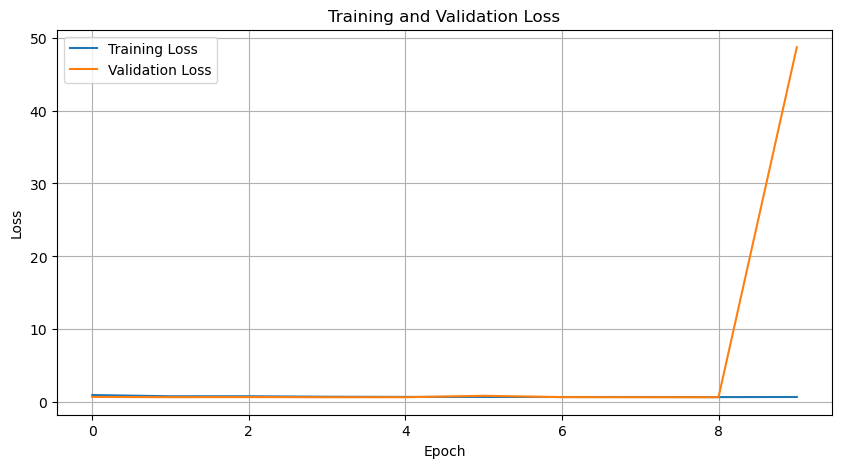

8/8 [==============================] - 6s 507ms/step


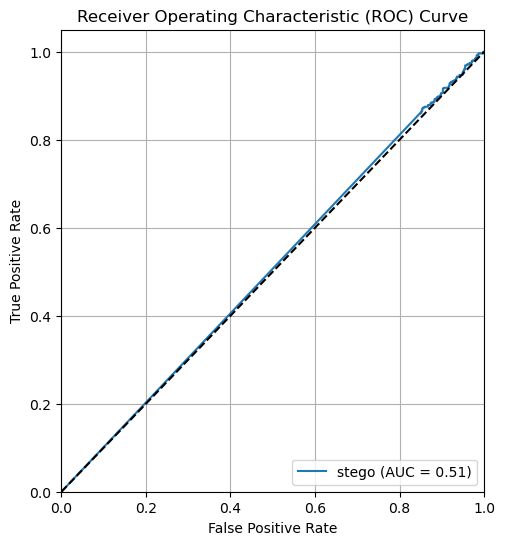

<Figure size 600x600 with 0 Axes>

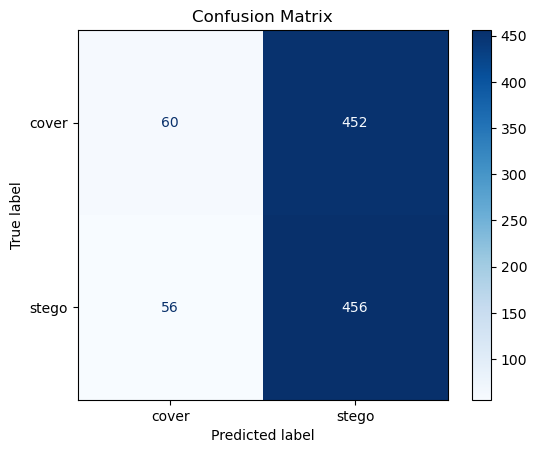


Classification Report:
              precision    recall  f1-score   support

       cover       0.52      0.12      0.19       512
       stego       0.50      0.89      0.64       512

    accuracy                           0.50      1024
   macro avg       0.51      0.50      0.42      1024
weighted avg       0.51      0.50      0.42      1024



In [28]:
plot_training_results(history, model, validation_generator)